<a href="https://colab.research.google.com/github/joaoAngelo2/classificacao_citacoes/blob/main/Modelo_classifica%C3%A7%C3%A3o_cita%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rota da apresentação:

Dados crus $\rightarrow$ Limpeza inicial + Feature Engineering $\rightarrow$ EDA $\rightarrow$ Modelagem

In [62]:
!pip install deep-translator

In [63]:
from google.colab import drive
import pandas as pd
import numpy as np
#importando os gráficos
import seaborn
import matplotlib.pyplot as plt

#transforma palavra -> vetor numérico
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm #temporaziador
import time
import requests
import ast


from deep_translator import GoogleTranslator #tradutor

# Os dados "crus":

In [64]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/RBIE/SBIE20/SBIE20/sbie_2001_2024.csv')

print(df.head)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<bound method NDFrame.head of                                                     url   ano  \
0     https://www.br-ie.org/pub/index.php/sbie/downl...  2019   
1     https://www.br-ie.org/pub/index.php/sbie/downl...  2019   
2     https://www.br-ie.org/pub/index.php/sbie/downl...  2019   
3     https://www.br-ie.org/pub/index.php/sbie/downl...  2019   
4     https://www.br-ie.org/pub/index.php/sbie/downl...  2019   
...                                                 ...   ...   
3219  https://sol.sbc.org.br/index.php/sbie/article/...  2020   
3220  https://sol.sbc.org.br/index.php/sbie/article/...  2020   
3221  https://sol.sbc.org.br/index.php/sbie/article/...  2020   
3222  https://sol.sbc.org.br/index.php/sbie/article/...  2020   
3223  https://sol.sbc.org.br/index.php/sbie/article/...  2020   

                                                 titulo  \
0

# Realizando a limpeza inicial dos dados






In [65]:

#preenchendo valores não coletados
df['citacoes'] = df['citacoes'].fillna(0)

#removendo informações
df = df[
         ~(df['titulo'].str.startswith('Contra-capa') |
         df['titulo'].str.startswith('Capa dos anais'))
         | df['titulo'].str.startswith('Editorial')
         | df['titulo'].str.startswith('Elementos pré-textuais')]

df['citacoes'] = df['citacoes'].astype(int)
#removendo artigos sem resumo
df  = df[df['resumo'].notna()]


In [66]:

def parse_afiliacoes(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    elif isinstance(x, list):
        return x
    else:
        return []

df['afiliacoes'] = df['afiliacoes'].apply(parse_afiliacoes)

todas_instituicoes = set()
for aff_list in df['afiliacoes']:
    if isinstance(aff_list, list):
        for autor in aff_list:
            if isinstance(autor, dict) and 'id_afiliacoes' in autor:
                todas_instituicoes.update(autor['id_afiliacoes'])

print(f"Total de instituições únicas: {len(todas_instituicoes)}")

def get_nome_instituicao(openalex_id):
    if not openalex_id:
        return None
    inst_id = openalex_id.split('/')[-1]
    url = f'https://api.openalex.org/institutions/{inst_id}'
    resp = requests.get(url)
    if resp.status_code == 200:
        data = resp.json()
        return data.get('display_name', None)
    return None

instituicao_nomes = {}
for inst_id in tqdm(todas_instituicoes, desc="Buscando nomes no OpenAlex"):
    nome = get_nome_instituicao(inst_id)
    instituicao_nomes[inst_id] = nome if nome else inst_id

for inst_id, nome in instituicao_nomes.items():
    nome_limpo = nome.replace(" ", "_").replace(",", "").replace(".", "")
    col_name = nome_limpo[:50]  # limitar tamanho se necessário
    df[col_name] = 0

for idx, aff_list in df['afiliacoes'].items():
    if isinstance(aff_list, list):
        ids = set()
        for autor in aff_list:
            if isinstance(autor, dict) and 'id_afiliacoes' in autor:
                ids.update(autor['id_afiliacoes'])
        for inst_id in ids:
            nome = instituicao_nomes.get(inst_id, inst_id)
            nome_limpo = nome.replace(" ", "_").replace(",", "").replace(".", "")
            col_name = nome_limpo[:50]
            df.at[idx, col_name] = 1


Total de instituições únicas: 439


Buscando nomes no OpenAlex: 100%|██████████| 439/439 [01:39<00:00,  4.42it/s]
/tmp/ipython-input-2189201589.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = 0
/tmp/ipython-input-2189201589.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = 0
/tmp/ipython-input-2189201589.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

# Coletando o "Corpus" titulo + resumo para transformação em vetores numéricos

In [67]:
corpus = (df['resumo'] + df['titulo']).to_list()

Realizando a normalização do corpus PT $\rightarrow$ EN

In [68]:
tradutor = GoogleTranslator(source='pt', target='en')

def traduzir_texto(texto):
    try:
        traducao = tradutor.translate(texto)
        time.sleep(0.1)
        return traducao
    except Exception as e:
        return ""

corpus_traduzido = []

for texto in tqdm(corpus, desc="Traduzindo artigos", ncols=100):
    corpus_traduzido.append(traduzir_texto(texto))


Traduzindo artigos: 100%|███████████████████████████████████████| 3214/3214 [10:07<00:00,  5.29it/s]



Binarizando o nosso **target** $y$
---
$
y =
\begin{cases}
0, & \text{se citações } \leq  \text{mediana} \\
1, & \text{caso contrário }
\end{cases}
\ $


In [69]:
mediana = (int(df['citacoes'].median()))

df['citacoes'] = df['citacoes'].apply(lambda x: 0 if x <= mediana else 1)

print(df['citacoes'].value_counts(normalize=True))

citacoes
0    0.606098
1    0.393902
Name: proportion, dtype: float64


Ajustando desequilibrio

In [70]:

contagem = df['citacoes'].value_counts()
classe_0 = 0
classe_1 = 1

if contagem[0] > contagem[1]:
    majoritaria = 0
    minoritaria = 1
else:
    majoritaria = 1
    minoritaria = 0

target = contagem[minoritaria]

indices_remover = []


for idx, linha in df.iterrows():
    if linha['citacoes'] == majoritaria and len(indices_remover) < (contagem[majoritaria] - target):
        indices_remover.append(idx)

df_balanceado = df.drop(indices_remover)


In [71]:
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english') #pegando as 1000 palavras mais relevantes
X_text = vectorizer.fit_transform(corpus_traduzido)

In [72]:
X_text_df = pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out())
X_text_df.reset_index(drop=True, inplace=True)
X_text_df = X_text_df.drop(indices_remover).reset_index(drop=True)

In [73]:
df_completo = pd.concat([
    df_balanceado.reset_index(drop=True),
    X_text_df.reset_index(drop=True)
], axis=1)

# Análise exploratória dos dados


**Passo 1**: Entendimento dos dados


*   Visão geral dos dados (*shape, head, tail, sample, dtypes*)
*   resumo estatístico (*describe*)


**Passo 2**: limpeza e organização dos dados

*   Apagar colunas e linhas desnecessárias
*   Identificar colunas duplicadas
*   Corrigir nomes, valores etc.
*   Renomear colunas

**Passo 3**: Gráfico para entender as variáveis

*   Variáveis quantitativas: histogramas, KDE, *boxplots*
*   Variáveis qualitativas: gráficos de colunas, barras, linha, pizza

**Passo 4**: Relação entre variáveis

*   Diagramas de dispersão
*   Mapas de calor (*heatmaps*)
*   Agrupamento de dados: *groupby*

**Passo 5**: Elaborar uma questão sobre os dados



##### fontes:
https://www.each.usp.br/lauretto/SIN5008_2011/aula01/aula1.pdf

https://www.youtube.com/watch?v=woObL4Mx9ns


In [74]:
df_completo.head()

,url,ano,titulo,autores,resumo,id_paper,citacoes,afiliacoes,Univates,Lampung_University,...,widely,work,working,works,world,writing,written,year,years,young
0,https://www.br-ie.org/pub/index.php/sbie/downl...,2019,Uma Análise do Sequenciamento Pedagógico no En...,"['Nathalia Alves', 'Christiane Gresse von Wang...",Several curriculum frameworks have been propos...,https://openalex.org/W2991363149,1,"[{'nome': 'Nathalia da Cruz Alves', 'id_autor'...",0,0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,https://www.br-ie.org/pub/index.php/sbie/downl...,2019,Autenticidade na aprendizagem baseada em proje...,"['Vinícius Ferreira', 'Edna Canedo']",Este trabalho apresenta uma revisão sistemátic...,https://openalex.org/W2991619052,1,"[{'nome': 'V.F. Ferreira', 'id_autor': 'https:...",0,0,...,0.0,0.052828,0.0,0.115705,0.0,0.0,0.0,0.0,0.0,0.0
2,https://www.br-ie.org/pub/index.php/sbie/downl...,2019,Online Student Engagement: A Case Study in Tea...,"['Mirna Carelli Maia', 'Jorge César Abrantes d...",Technological support changed the teaching-lea...,https://openalex.org/W2989674602,1,"[{'nome': 'Mirna Carelli Oliveira Maia', 'id_a...",0,0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,https://www.br-ie.org/pub/index.php/sbie/downl...,2019,Aprendizagem baseada em projetos aplicada em u...,"['Ricardo Ajax Kosloski', 'Cristiane Ramos', '...",This paper presents an experience case report ...,https://openalex.org/W2991110921,1,"[{'nome': 'Ricardo Ajax Dias Kosloski', 'id_au...",0,0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,https://www.br-ie.org/pub/index.php/sbie/downl...,2019,Small Private Online Courses in Computing Lear...,"['Jorge Prates', 'Rogerio Garcia', 'José Maldo...",SPOCs (Small Private Online Courses) are consi...,https://openalex.org/W2989857383,1,"[{'nome': 'Jorge Prates', 'id_autor': 'https:/...",0,0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
df_completo.describe()

,ano,citacoes,Univates,Lampung_University,Centro_Universitário_Barão_de_Mauá,Estácio_(Brazil),Instituto_Federal_de_Educação_Ciência_e_Tecnologia,Instituto_Federal_do_Amazonas,Unichristus,Instituto_Federal_Sul-rio-grandense,...,widely,work,working,works,world,writing,written,year,years,young
count,2532.000000,2532.000000,2532.000000,2532.000000,2532.0,2532.000000,2532.000000,2532.000000,2532.000000,2532.000000,...,2532.000000,2532.000000,2532.000000,2532.000000,2532.000000,2532.000000,2532.000000,2532.000000,2532.000000,2532.000000
mean,2014.268562,0.500000,0.000395,0.000395,0.0,0.001580,0.037520,0.005924,0.000790,0.004344,...,0.002622,0.026075,0.002226,0.005881,0.005156,0.004594,0.002414,0.003274,0.006185,0.002539
std,7.158128,0.500099,0.019873,0.019873,0.0,0.039723,0.190069,0.076755,0.028099,0.065782,...,0.019347,0.037423,0.019239,0.031515,0.031835,0.035068,0.022239,0.023493,0.028835,0.025190
min,2001.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2008.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.000000,0.500000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2021.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.054028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2024.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.201558,0.386559,0.336802,0.514756,0.580470,0.588958,0.426583,0.298053,0.335689,0.485884


In [76]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2532 entries, 0 to 2531
Columns: 1431 entries, url to young
dtypes: float64(1000), int64(425), object(6)
memory usage: 27.6+ MB


Número de dados nulos por coluna

In [77]:
df_completo.isna().sum()

,0
url,0
ano,0
titulo,0
autores,0
resumo,0
...,...
writing,0
written,0
year,0
years,0


Limpando os dados

In [87]:
df_completo = df_completo.drop(['id_paper'],axis=1)

In [88]:
df_completo.columns

Index(['ano', 'citacoes', 'Univates', 'Lampung_University',
       'Centro_Universitário_Barão_de_Mauá', 'Estácio_(Brazil)',
       'Instituto_Federal_de_Educação_Ciência_e_Tecnologia',
       'Instituto_Federal_do_Amazonas', 'Unichristus',
       'Instituto_Federal_Sul-rio-grandense',
       ...
       'widely', 'work', 'working', 'works', 'world', 'writing', 'written',
       'year', 'years', 'young'],
      dtype='object', length=1425)

# Criando gráficos

## Análise qualitativa

<Axes: xlabel='ano'>

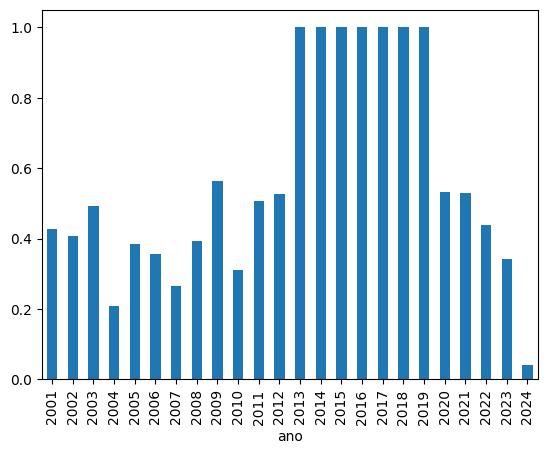

In [89]:
df_completo.groupby('ano')['citacoes'].mean().plot(kind='bar')

<Axes: >

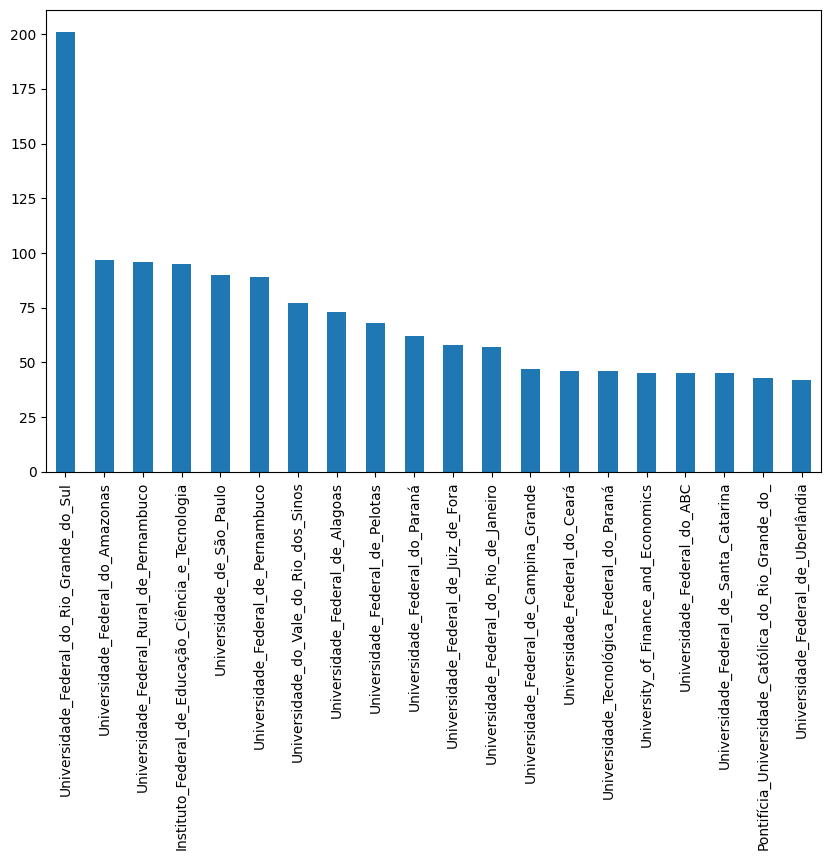

In [90]:
# gráfico de pizza distribuição de universidades -> apresentamos somente as 20 mais por conta da quantidade
plt.figure(figsize=(10,6))
top_universidades = df_completo.iloc[:, 2:441].sum().sort_values(ascending=False).head(20)
top_universidades.plot(kind='bar')

<Axes: >

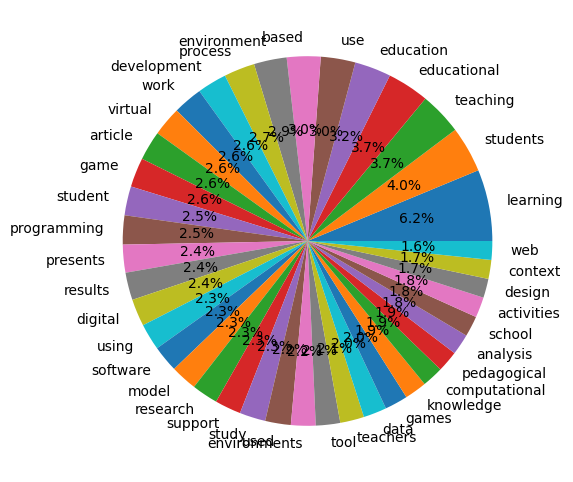

In [91]:
#gráfico de distribuição de palavras 40 mais pq sao muitas
plt.figure(figsize=(10,6))
top_palavras = df_completo.iloc[:, 442:1425].sum().sort_values(ascending=False).head(40)
top_palavras.plot(kind='pie', autopct='%1.1f%%')

## Análise quantitativa

In [92]:
muito_citado = df_completo[df_completo['citacoes'] == 1]
baixo_citado = df_completo[df_completo['citacoes'] == 0]

#pegando as frequencias
freq_bem = muito_citado.iloc[:, 442:1425].mean().sort_values(ascending=False)
freq_baixo = baixo_citado.iloc[:, 442:1425].mean().sort_values(ascending=False)


comparativo = pd.DataFrame({
    "freq_bem_citado": freq_bem,
    "freq_pouco_citado": freq_baixo,
    "diferenca": freq_bem - freq_baixo
}).sort_values("diferenca", ascending=False)

comparativo.head(10)

,freq_bem_citado,freq_pouco_citado,diferenca
games,0.025461,0.015352,0.010109
gamification,0.015302,0.005457,0.009845
systematic,0.018433,0.009756,0.008677
game,0.029833,0.022248,0.007585
mobile,0.013411,0.006286,0.007125
objects,0.018643,0.012855,0.005789
recommendation,0.008729,0.002964,0.005765
programming,0.028496,0.022943,0.005553
mapping,0.013256,0.007751,0.005504
techniques,0.013549,0.008063,0.005487


# Criando o modelo classificador - SVM

In [93]:
df_completo.to_csv("df_final.csv")

In [94]:
X = df_completo.drop(columns=['citacoes'])
y = df_completo['citacoes']

In [95]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

clf = SVC(kernel='rbf', C=20, gamma=0.1)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6894736842105263
